# Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split


# Load the Data

In [4]:
# Load the data
df = pd.read_csv("cleaned_plyear_data.csv")

In [5]:
df

,Team,Position,Height,Age,Appearances,Goals,Assists,Yellow_Cards,Second_Yellow_Cards,Red_Cards,Goals_Conceded,Clean_Sheets,Minutes_Played,Days_Injured,Games_Injured,Award,Current_Value,Highest_Value,Position_Encoded,Winger
0,Manchester United,Goalkeeper,196.000000,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
1,Manchester United,Goalkeeper,188.000000,37.0,4,0.000000,0.000000,0.000000,0.0,0.000000,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
2,Manchester United,Defender Centre-Back,185.000000,31.0,8,0.000000,0.000000,0.216346,0.0,0.000000,0.000000,0.000000,416,932,169,7,2000000,20000000,2,0
3,Manchester United,Defender Centre-Back,186.000000,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,2000000,2,0
4,Manchester United,Defender Left-Back,169.000000,23.0,89,0.012619,0.063096,0.227145,0.0,0.000000,0.000000,0.000000,7132,182,15,3,22000000,22000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,4,1
10299,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,4,0
10300,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,4,0
10301,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,4,0


# Aggregat
Aggregating categorical feature

In [7]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Team', 'Position'], dtype='object')

#  One hot encoding

In [9]:
# One hot encoding
categorical_features = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_features)

# Split the players to 3 categories by percentiles

In [11]:
# Split the players to 3 categories by percentiles
p60 = df['Current_Value'].quantile(0.60)
p90 = df['Current_Value'].quantile(0.90)

def categorize_Current_Value(Current_Value):
    if Current_Value < p60:
        return 'good player'
    elif Current_Value < p90:
        return 'Excellent player'
    else:
        return 'legend'

df['categorize_Current_Value'] = df['Current_Value'].apply(categorize_Current_Value)
df.drop('Current_Value', axis=1, inplace=True)

# encoder

In [13]:
# Encode the target variable
encoder = LabelEncoder()
df['categorize_Current_Value'] = encoder.fit_transform(df['categorize_Current_Value'])  

# Feature selection
- Step 1 : Calculate Correlation Matrix
- Step 2 : Set Correlation Threshold
- Step 3 : Select Features Based on Correlation

In [15]:
# Feature selection based on correlation
correlation = df.corr(numeric_only=True)
threshold = 0.07 
selected_features = correlation[abs(correlation['categorize_Current_Value']) > threshold].index


# Data Scaling
- Selecting relevant features.
- Separating the target variable.
- Standardizing the feature values to have a mean of 0 and a standard deviation of 1.

In [17]:
# Data Scaling
X = df[selected_features].drop(['categorize_Current_Value'], axis=1)
y = df['categorize_Current_Value']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
wcss = []
for i in range(2, 10):  
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

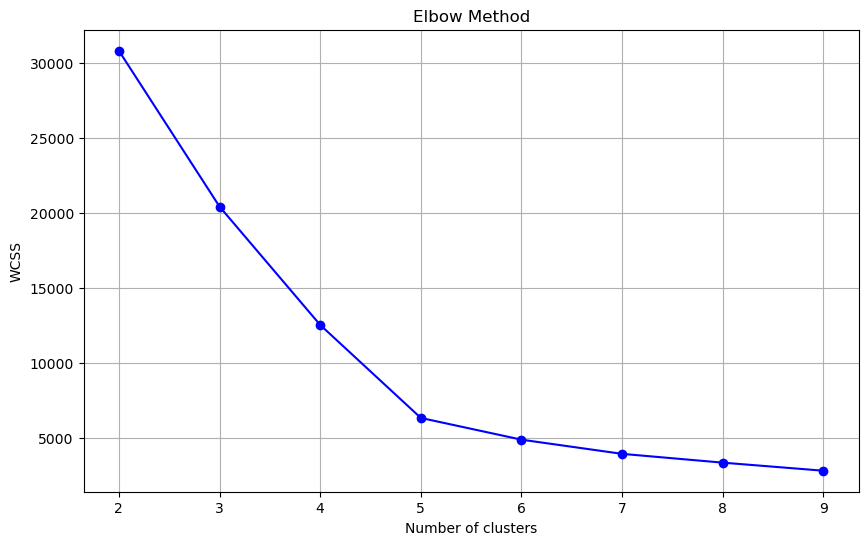

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Grid Search Cross-Validation
This code performs a comprehensive search to find the best hyperparameters for K-Means clustering using Grid Search Cross-Validation

In [21]:
param_grid_kmeans = {
    'n_clusters': [2,3, 4, 5, 6, 7, 8, 9,10],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 400, 500]
}

kmeans = KMeans()
grid_search_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid_kmeans, cv=5, scoring='accuracy')
grid_search_kmeans.fit(X_scaled)

best_params_kmeans = grid_search_kmeans.best_params_
best_kmeans = KMeans(n_clusters=best_params_kmeans['n_clusters'],
                     init=best_params_kmeans['init'],
                     max_iter=best_params_kmeans['max_iter'])
best_kmeans.fit(X_scaled)

KMeans(n_clusters=2)

In [22]:
# Building the KMeans Model
#optimal_clusters = 7
#best_kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# evaluate model

In [24]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# Split the data to train and test

In [26]:
for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Fit the model
    y_pred_train = best_kmeans.fit_predict(X_train)
    
    # Assign cluster labels to the test set
    y_pred_test = best_kmeans.predict(X_test)
    
    # Evaluate the clustering using adjusted rand index
    score = metrics.adjusted_rand_score(y_test, y_pred_test)
    scores.append(score)

# Output the cross-validation scores for KMeans

In [28]:
print(f'Best KMeans Parameters: {best_kmeans}')
print(f'Cross-Validation Scores for KMeans: {scores}')
print(f'Mean Cross-Validation Score for KMeans: {np.mean(scores)}')

Best KMeans Parameters: KMeans(n_clusters=2)
Cross-Validation Scores for KMeans: [0.045649969811708095, 0.04505199557167995, 0.05253092172149154, 0.0032938849383777, 0.05493195036569843]
Mean Cross-Validation Score for KMeans: 0.04029174448179114


# Train the model

In [30]:
# Final Model Training
y_pred = kmeans.fit_predict(X_scaled)

# Clusters distribution

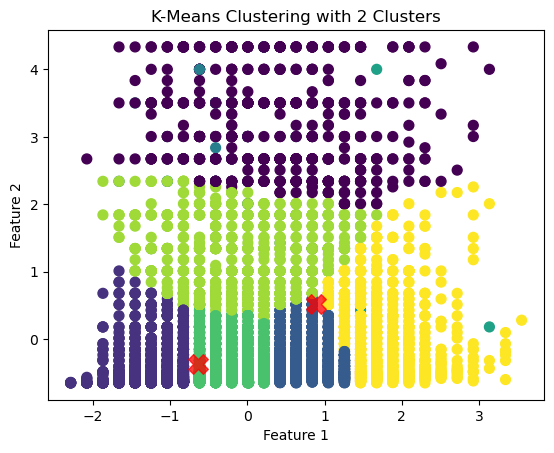

In [32]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, s=50, cmap='viridis')
centers = best_kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {best_params_kmeans["n_clusters"]} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Text(0.5, 0, 'Feature 3')

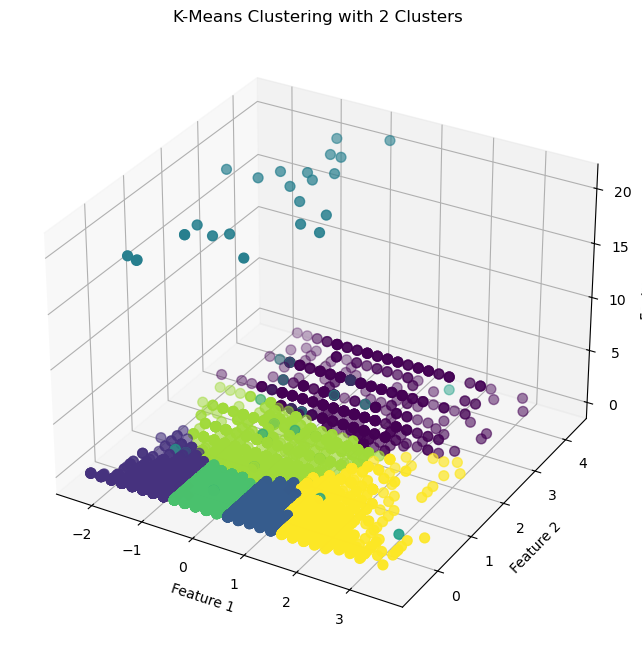

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of points
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y_pred, s=50, cmap='viridis')

# Scatter plot of cluster centers
centers = best_kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.75, marker='X')

ax.set_title(f'K-Means Clustering with {best_params_kmeans["n_clusters"]} Clusters')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

In [61]:
dict_f = {
         'Age': 30,
    'Appearances': 15,
    'Goals': 20,
    'Position_Attack-SecondStriker': True,
    
             }
scaler.transform(np.array([list(dict_f.values())]))

array([[  0.83973986,  -0.65077412, 414.8222626 ,  18.82221725]])

In [63]:
from fastapi.encoders import jsonable_encoder
json_compatible_data = jsonable_encoder(dict_f)

In [65]:
np.array([list(dict_f.values())])

array([[30, 15, 20,  1]])

In [67]:
import joblib
joblib.dump(kmeans, 'kmens_model.joblib')
joblib.dump(scaler, 'kmens_scaler.joblib')

['kmens_scaler.joblib']